In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
pip install transformers datasets scikit-learn pandas evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is i

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
import numpy as np
import evaluate

In [ ]:
tweet_dataset = pd.read_csv('/content/gdrive/MyDrive/tweet_data.csv')
tweet_dataset = tweet_dataset[['Text', 'Sentiment']]

In [ ]:
tweet_dataset.iloc[0]

,0
Text,Working overtime so I can pay more taxes. Livi...
Sentiment,-1.0


In [ ]:
# Remap labels from {-1.0, 0, 1.0} to {0, 1, 2}
label_mapping = {-1: 0, 0: 1, 1: 2}
tweet_dataset['Sentiment'] = tweet_dataset['Sentiment'].map(label_mapping)

In [ ]:
train_df, test_df = train_test_split(tweet_dataset, test_size=0.2, random_state=42)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    result = tokenizer(examples['Text'], truncation=True, padding=True, max_length=512)
    result['labels'] = [int(label) if label is not None else -100 for label in examples['Sentiment']]
    return result

# Tokenize the data
train_encodings = tokenizer(list(train_df['Text']), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(list(test_df['Text']), truncation=True, padding=True, max_length=512, return_tensors="pt")

# Convert labels to tensors
train_labels = torch.tensor(train_df['Sentiment'].values)
test_labels = torch.tensor(test_df['Sentiment'].values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Check for None values
print("None values in train set:", train_df['Sentiment'].isnull().sum())
print("None values in test set:", test_df['Sentiment'].isnull().sum())

# Remove rows with None values (if any)
train_df = train_df.dropna(subset=['Sentiment'])
test_df = test_df.dropna(subset=['Sentiment'])

# Reset index after dropping rows
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

None values in train set: 4
None values in test set: 0


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=test_dataset.column_names)

# Set the format of the datasets
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/3628 [00:00<?, ? examples/s]

Map:   0%|          | 0/909 [00:00<?, ? examples/s]

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='/content/gdrive/MyDrive/Bert_model',   # Output directory
    num_train_epochs=4,              # Number of training epochs
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # Evaluate at each epoch
    save_strategy="epoch",           # Save the model at each epoch
    load_best_model_at_end=True,     # Load the best model when finished training
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
from datasets import load_metric

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy


<ipython-input-16-0f6757ccba1f>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.537000,0.553871,0.774477
2,0.404900,0.501917,0.810781
3,0.318100,0.495542,0.804180
4,0.164700,0.564246,0.817382


TrainOutput(global_step=908, training_loss=0.4117609486968507, metrics={'train_runtime': 369.6465, 'train_samples_per_second': 39.259, 'train_steps_per_second': 2.456, 'total_flos': 645140155226976.0, 'train_loss': 0.4117609486968507, 'epoch': 4.0})

Accuracy: 0.8042
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       357
           1       0.55      0.65      0.59       156
           2       0.89      0.81      0.85       396

    accuracy                           0.80       909
   macro avg       0.76      0.77      0.77       909
weighted avg       0.82      0.80      0.81       909



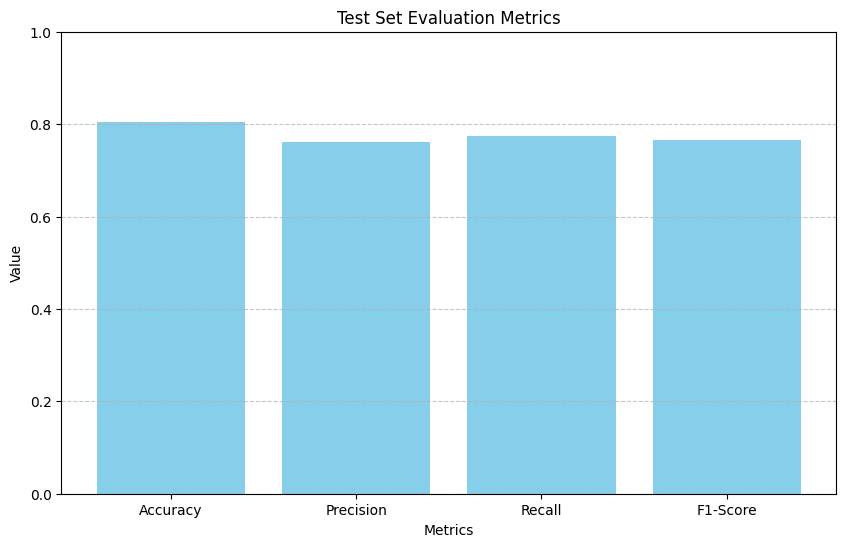

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Perform predictions on the test set
predictions, labels, _ = trainer.predict(test_dataset)

# Get the predicted class by taking the argmax of the logits
y_pred = np.argmax(predictions, axis=-1)
y_test = labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate and print the classification report
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Extract precision, recall, and f1-score for the overall macro average
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1 = report['macro avg']['f1-score']

# Store the metrics in a dictionary for plotting, with accuracy first
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Plot the metrics in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Test Set Evaluation Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
output_dir = "/content/gdrive/MyDrive/Bert_model/"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/gdrive/MyDrive/Bert_model/tokenizer_config.json',
 '/content/gdrive/MyDrive/Bert_model/special_tokens_map.json',
 '/content/gdrive/MyDrive/Bert_model/vocab.txt',
 '/content/gdrive/MyDrive/Bert_model/added_tokens.json')